
Sample Prediction: 0 (True Label: 0)

SHAP Values for the Sample:
age: 3.7056
gender: -0.7230
hypertension: 0.3772
heart_disease: 0.1518
ever_married: -0.4635
work_type: 0.0794
Residence_type: 0.5401
avg_glucose_level: -0.1782
bmi: 0.0862
smoking_status: -0.2468
age_glucose: 0.0063
comorbidity: -0.3572
age_group: -2.2390


C:\Users\Shubham\AppData\Local\Temp\ipykernel_28972\3853018644.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['bmi'].fillna(data['bmi'].median(), inplace=True)
c:\Users\Shubham\Documents\ds_mini\mini\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


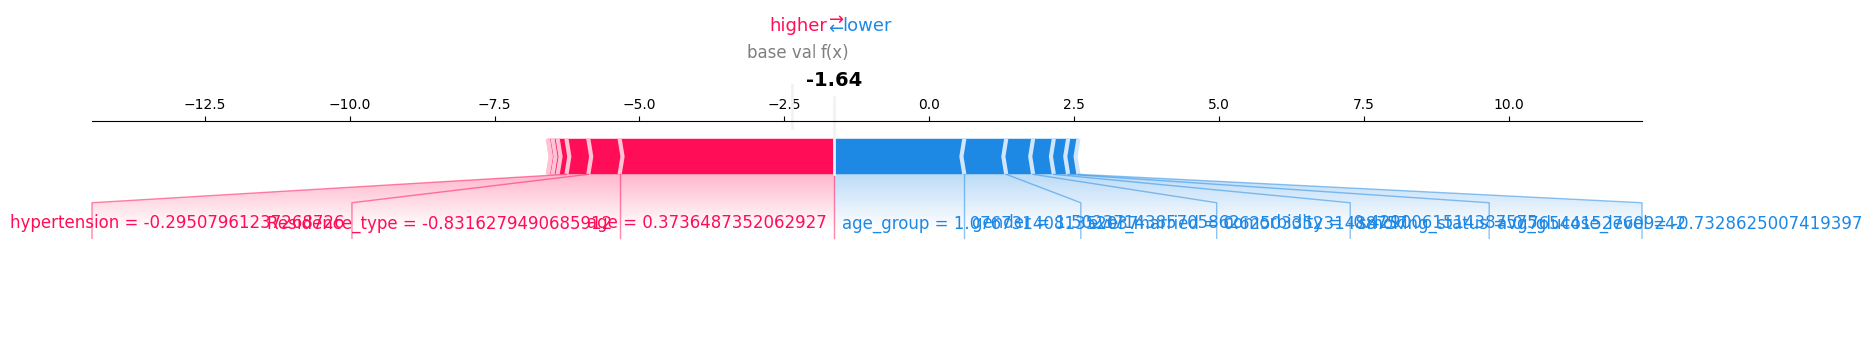

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import shap
import matplotlib.pyplot as plt

# Load the dataset (replace 'healthcare-dataset-stroke-data.csv' with your file path)
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

# Drop 'id' column if present
if 'id' in data.columns:
    data = data.drop('id', axis=1)

# Handle missing values
data['bmi'].fillna(data['bmi'].median(), inplace=True)

# Encode categorical variables
le = LabelEncoder()
categorical_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

# Create derived features
data['age_glucose'] = data['age'] * data['avg_glucose_level']
data['comorbidity'] = data['hypertension'] | data['heart_disease']
data['age_group'] = pd.cut(data['age'], bins=[0, 40, 60, 120], labels=[0, 1, 2], include_lowest=True)
data['age_group'] = data['age_group'].astype(int)

# Define features and target
X = data[['age', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type',
          'avg_glucose_level', 'bmi', 'smoking_status', 'age_glucose', 'comorbidity', 'age_group']]
y = data['stroke']

# Split the data to get X_test and y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load the saved scaler and model
scaler = joblib.load('scalers/Logistic_scaler_smote_new.pkl')
model = joblib.load('models1/logistic_regression_smote_model.pkl')

# Scale the test set
X_test_scaled = scaler.transform(X_test)

# Convert the scaled test set back to a DataFrame for SHAP (with feature names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Select a sample from the test set (e.g., the first sample)
sample_idx = 0
sample = X_test_scaled_df.iloc[[sample_idx]]

# Initialize the SHAP explainer
explainer = shap.LinearExplainer(model, X_test_scaled_df)

# Compute SHAP values for the sample
shap_values = explainer.shap_values(sample)

# Get the base value (expected value of the model output)
base_value = explainer.expected_value

# Print the prediction and true label
sample_pred = model.predict(sample)[0]
sample_true = y_test.iloc[sample_idx]
print(f"\nSample Prediction: {sample_pred} (True Label: {sample_true})")

# Print the SHAP values for the sample
print("\nSHAP Values for the Sample:")
for feature, shap_val in zip(X_test.columns, shap_values[0]):
    print(f"{feature}: {shap_val:.4f}")

# Visualize the explanation using a force plot
shap.initjs()  # Initialize JavaScript visualization for force plot
shap.force_plot(base_value, shap_values[0], sample, matplotlib=True)
plt.show()

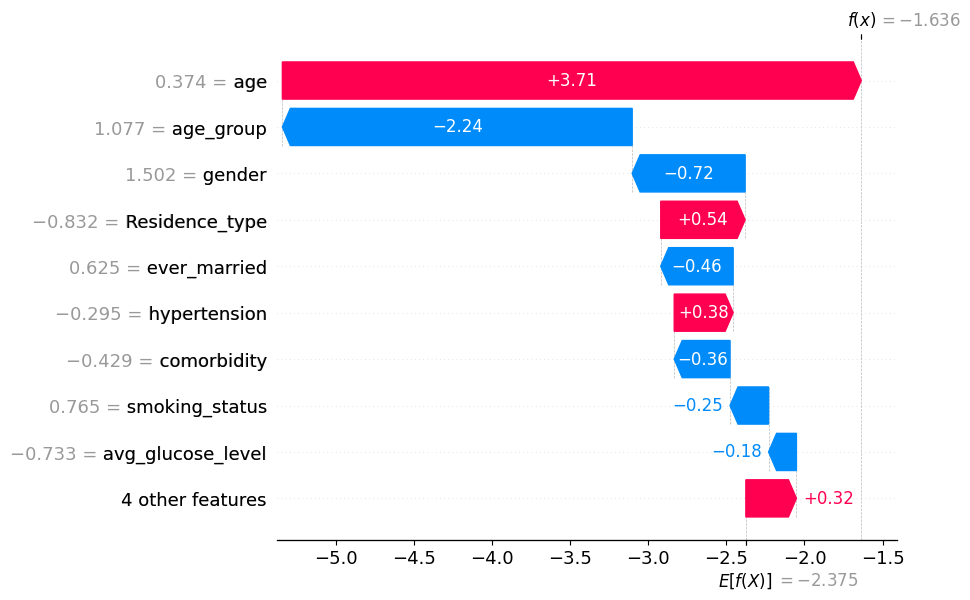

In [9]:
# Generate a SHAP waterfall plot for the sample
shap.waterfall_plot(shap.Explanation(values=shap_values[0], 
                                     base_values=base_value, 
                                     data=sample.iloc[0], 
                                     feature_names=X_test.columns))
plt.show()

In [10]:
# Print the unscaled feature values for the sample
print("\nUnscaled Feature Values for the Sample:")
print(X_test.iloc[[sample_idx]])

# Print the scaled feature values for the sample
print("\nScaled Feature Values for the Sample:")
print(sample)


Unscaled Feature Values for the Sample:
       age  gender  hypertension  heart_disease  ever_married  work_type  \
3725  63.0       1             0              0             1          2   

      Residence_type  avg_glucose_level   bmi  smoking_status  age_glucose  \
3725               0              78.23  34.8               2      4928.49   

      comorbidity  age_group  
3725            0          2  

Scaled Feature Values for the Sample:
        age    gender  hypertension  heart_disease  ever_married  work_type  \
0  0.373649  1.502371      -0.29508      -0.225382      0.625034   0.053389   

   Residence_type  avg_glucose_level       bmi  smoking_status  age_glucose  \
0       -0.831628          -0.732863  0.801466        0.765442    -0.403428   

   comorbidity  age_group  
0    -0.429006   1.076731  


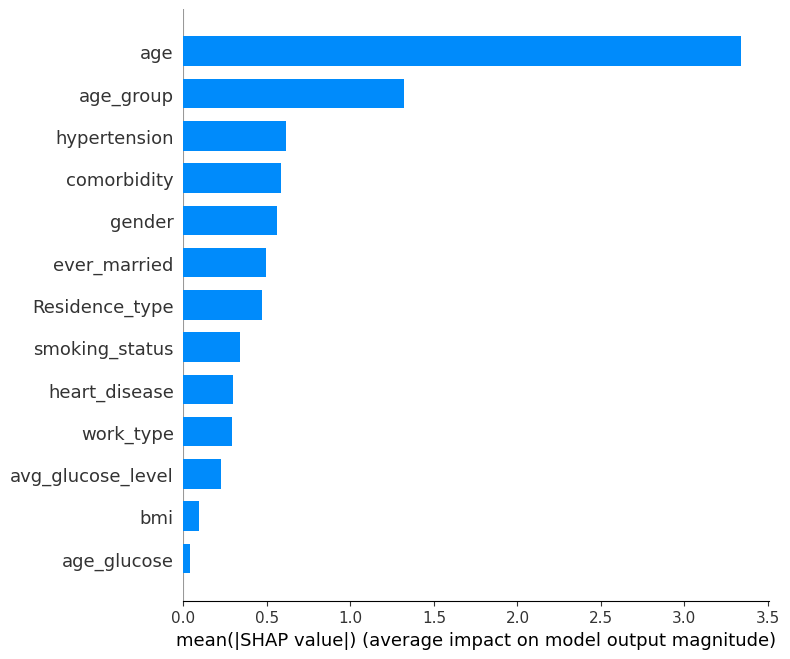

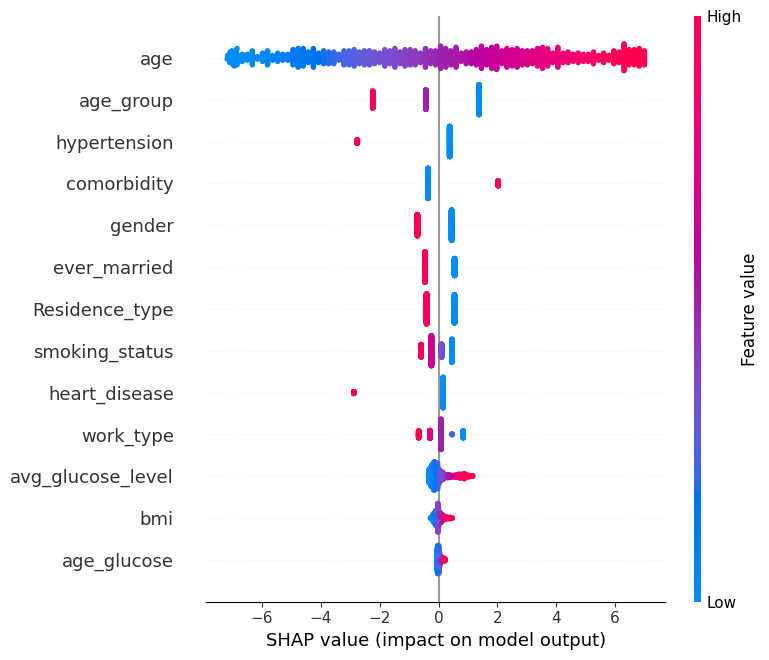

In [11]:
# Compute SHAP values for the entire test set
shap_values_test = explainer.shap_values(X_test_scaled_df)

# Generate a SHAP summary plot (bar plot style for readability)
shap.summary_plot(shap_values_test, X_test_scaled_df, plot_type="bar")
plt.show()

# Optionally, generate a SHAP summary plot (dot plot style to show feature value impact)
shap.summary_plot(shap_values_test, X_test_scaled_df)
plt.show()

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import joblib
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Load the dataset
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

# Drop 'id' column if present
if 'id' in data.columns:
    data = data.drop('id', axis=1)

# Handle missing values
data['bmi'].fillna(data['bmi'].median(), inplace=True)

# Encode categorical variables
le = LabelEncoder()
categorical_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

# Create derived features
data['age_glucose'] = data['age'] * data['avg_glucose_level']
data['comorbidity'] = data['hypertension'] | data['heart_disease']
data['age_group'] = pd.cut(data['age'], bins=[0, 40, 60, 120], labels=[0, 1, 2], include_lowest=True)
data['age_group'] = data['age_group'].astype(int)

# Define features and target
X = data[['age', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type',
          'avg_glucose_level', 'bmi', 'smoking_status', 'age_glucose', 'comorbidity', 'age_group']]
y = data['stroke']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame
X_train_smote_scaled_df = pd.DataFrame(X_train_smote_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Apply time-sensitive weights
weights = {
    'avg_glucose_level': 1.5, 'hypertension': 1.5, 'heart_disease': 1.5, 'comorbidity': 1.5,  # Short-term
    'age': 1.2, 'bmi': 1.2, 'smoking_status': 1.2, 'age_group': 1.2,  # Long-term
    'gender': 1.0, 'ever_married': 1.0, 'work_type': 1.0, 'Residence_type': 1.0, 'age_glucose': 1.0  # Neutral
}

for col in X_train_smote_scaled_df.columns:
    X_train_smote_scaled_df[col] = X_train_smote_scaled_df[col] * weights[col]
    X_test_scaled_df[col] = X_test_scaled_df[col] * weights[col]

# Load the previous tuned model to get the hyperparameters
previous_model = joblib.load('models1/logistic_regression_smote_model.pkl')
tuned_params = previous_model.get_params()

# Retrain the Logistic Regression model with the weighted features
model = LogisticRegression(**tuned_params)
model.fit(X_train_smote_scaled_df, y_train_smote)

C:\Users\Shubham\AppData\Local\Temp\ipykernel_28972\2940994844.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['bmi'].fillna(data['bmi'].median(), inplace=True)


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

In [ ]:
# # Save the updated model
# joblib.dump(model, 'models1/logistic_regression_smote_tuned_model_with_weighted_risk.pkl')
# print("Updated model saved as 'logistic_regression_smote_tuned_model_with_weighted_risk.pkl'")

# # Save the new scaler
# joblib.dump(scaler, 'scalers/scaler_smote_with_weighted_risk.pkl')
# print("Updated scaler saved as 'scaler_smote_with_weighted_risk.pkl'")

Updated model saved as 'logistic_regression_smote_tuned_model_with_weighted_risk.pkl'
Updated scaler saved as 'scaler_smote_with_weighted_risk.pkl'


run above code cell before this cuz the model in this cell comes from the model that was created in the up+up cell.
or just import it. but not sure if params and all is needed or not.


Sample Prediction: 0 (True Label: 0)

Unscaled Feature Values for the Sample:
       age  gender  hypertension  heart_disease  ever_married  work_type  \
3725  63.0       1             0              0             1          2   

      Residence_type  avg_glucose_level   bmi  smoking_status  age_glucose  \
3725               0              78.23  34.8               2      4928.49   

      comorbidity  age_group  
3725            0          2  

Scaled Feature Values for the Sample (After Weighting):
        age    gender  hypertension  heart_disease  ever_married  work_type  \
0  0.448378  1.502371     -0.442619      -0.338073      0.625034   0.053389   

   Residence_type  avg_glucose_level       bmi  smoking_status  age_glucose  \
0       -0.831628          -1.099294  0.961759         0.91853    -0.403428   

   comorbidity  age_group  
0    -0.643509   1.292078  

SHAP Values for the Sample (With Time-Sensitive Weights):
age: 3.7345
gender: -0.7238
hypertension: 0.3789
heart_dise

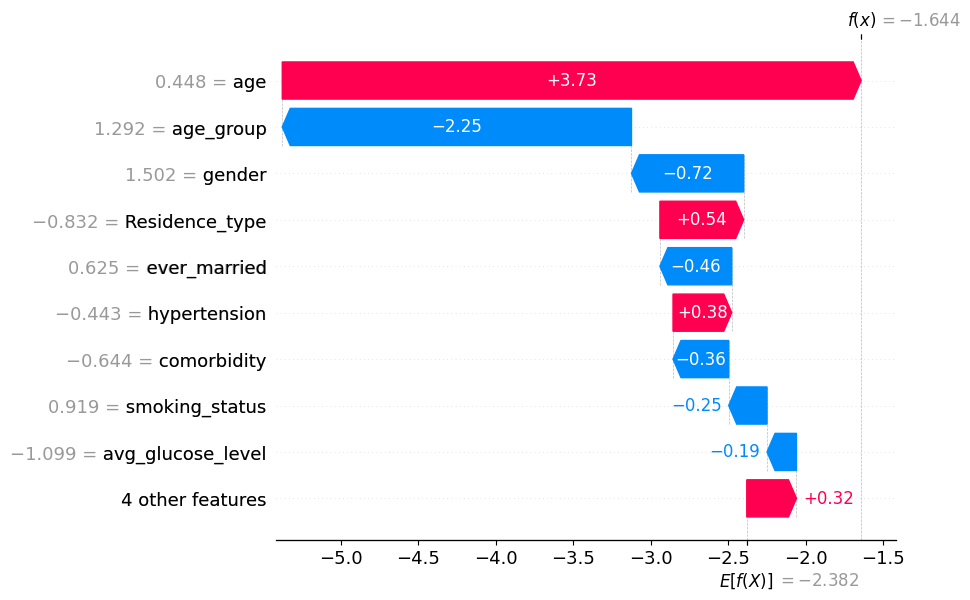

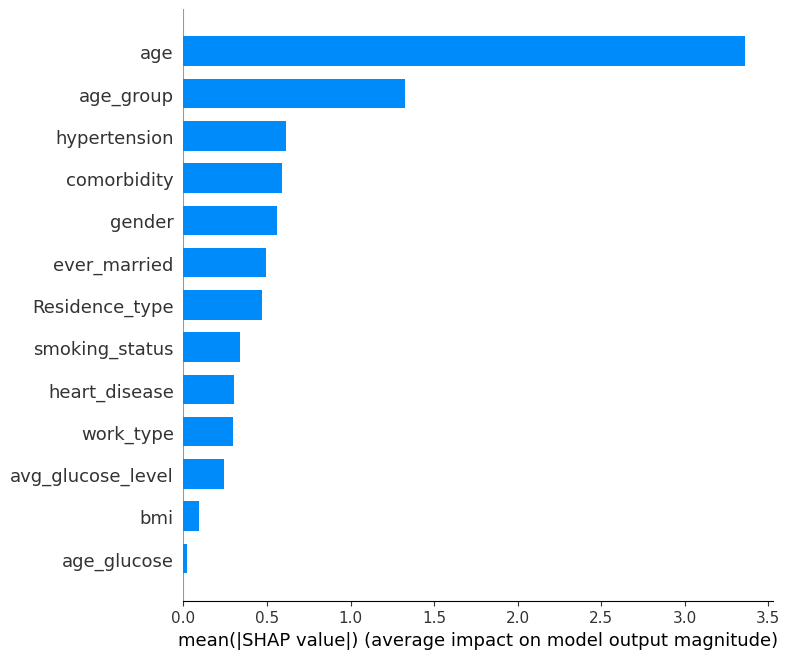

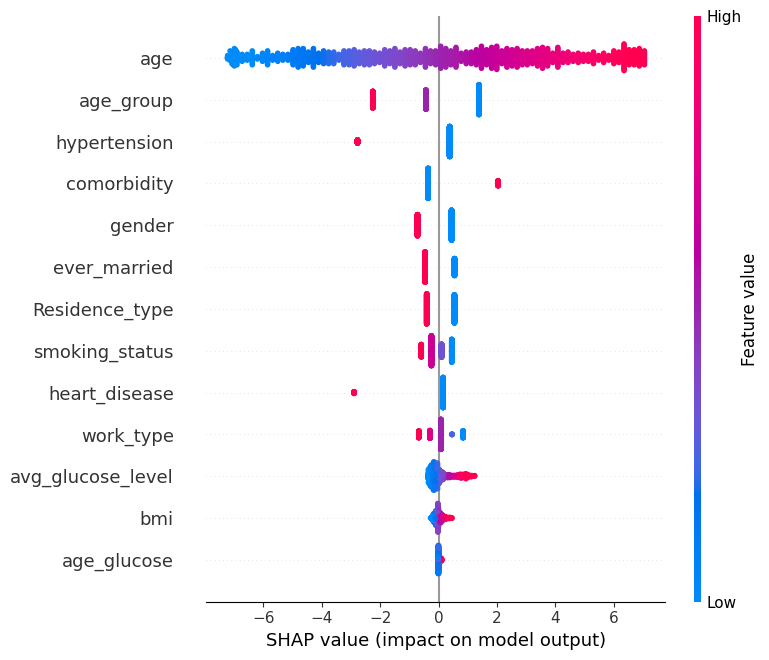

In [14]:
# Select the sample (index 0 in the test set)
sample_idx = 0
sample = X_test_scaled_df.iloc[[sample_idx]]

# Initialize the SHAP explainer
explainer = shap.LinearExplainer(model, X_test_scaled_df)

# Compute SHAP values for the sample
shap_values = explainer.shap_values(sample)

# Get the base value
base_value = explainer.expected_value

# Print the prediction and true label
sample_pred = model.predict(sample)[0]
sample_true = y_test.iloc[sample_idx]
print(f"\nSample Prediction: {sample_pred} (True Label: {sample_true})")

# Print the unscaled and scaled feature values for the sample
print("\nUnscaled Feature Values for the Sample:")
print(X_test.iloc[[sample_idx]])
print("\nScaled Feature Values for the Sample (After Weighting):")
print(sample)

# Print the SHAP values for the sample
print("\nSHAP Values for the Sample (With Time-Sensitive Weights):")
for feature, shap_val in zip(X_test.columns, shap_values[0]):
    print(f"{feature}: {shap_val:.4f}")

# Generate a SHAP waterfall plot for the sample
shap.waterfall_plot(shap.Explanation(values=shap_values[0], 
                                     base_values=base_value, 
                                     data=sample.iloc[0], 
                                     feature_names=X_test.columns))
plt.show()

# Compute SHAP values for the entire test set
shap_values_test = explainer.shap_values(X_test_scaled_df)

# Generate a SHAP summary plot (bar plot style for readability)
shap.summary_plot(shap_values_test, X_test_scaled_df, plot_type="bar")
plt.show()

# Generate a SHAP summary plot (dot plot style to show feature value impact)
shap.summary_plot(shap_values_test, X_test_scaled_df)
plt.show()